# DENSITY PEAKS ALGORYTHM

In [1]:
import numpy as np
from typing import NamedTuple, Tuple
from matplotlib import pyplot as plt
from numba import njit,jit, config #High performance JIT compiler and parallelization libraries

In [2]:
X_data = np.loadtxt("Aggregation.txt")
X_data = X_data[:,[0,1]]

In [3]:
def local_density(X: np.ndarray, kind, dc):
    """
    Compute all points' local density.
    :return: local density vector that index is the point index
    """
    n,d = X.shape
    rho_vector = np.zeros(n)
    rho_func = lambda dij, dc: np.exp(- (dij / dc) ** 2)
    cutoff_func = lambda dij, dc: 1 if dij < dc else 0
    func = rho_func if kind else cutoff_func
    distances = np.zeros((n,n))
        
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.sqrt(((X[i,:] - X[j,:])**2).sum(axis=0)) 
            distances[i, j] = distance
            distances[j, i] = distance
        
    for i in range(n):
        for j in range(i+1,n):
            temp = func(distances[i, j], dc)
            rho_vector[i] += temp
            rho_vector[j] += temp
    return rho_vector, distances

In [4]:
def delta_and_distance(X: np.ndarray, distances, rho):
    """
    Compute all points' min util to the higher local density point(which is the nearest neighbor).
    :return: distance vector, nearest neighbor vector
    """
    n,_ = X.shape
    sorted_rho = np.argsort(-rho)
    delta = np.zeros(n)
    near_neigh = np.zeros(n)
    
    delta[sorted_rho[0]] = distances[sorted_rho[0],:].max()
    max_dat = distances[sorted_rho[0],[i for i, x in enumerate(distances[sorted_rho[0],:]) if x.any()]]
    #near_neigh[sorted_rho[0]] = np.argmin(max_dat)
    near_neigh[sorted_rho[0]] = sorted_rho[0]
    #print(near_neigh[sorted_rho[0]])
    for i in range(1,n):
        min_delta= distances[sorted_rho[i],sorted_rho[0]]
        near_neigh[sorted_rho[i]] = sorted_rho[0]
        for j in range(2,i+1):
            if i == j:
                continue
            _delta= distances[sorted_rho[i],sorted_rho[j]]
            if _delta<min_delta:
                min_delta = _delta
                near_neigh[sorted_rho[i]] = sorted_rho[j]
        
        delta[sorted_rho[i]]= min_delta
            
    return delta, near_neigh

In [5]:
rho , distances = local_density(X_data,True,2.5)
sorted_rho = np.argsort(-rho)

In [6]:
delta, near_n= delta_and_distance(X_data,distances,rho)

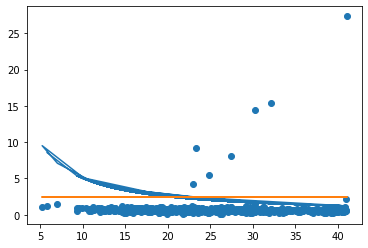

In [7]:
#Decision plot
n, _ = X_data.shape
plt.scatter(rho,delta)
plt.plot(rho,50/rho)
plt.plot(rho,[2.5]*n)

In [8]:
# Initial clusters
n , d = X_data.shape
centers = np.zeros((n,d))
cluster = np.zeros(n)
labels = np.zeros(n)
for idx, delta_val in enumerate(delta):
    
    if delta_val >= 2.5:
        cluster[idx] = idx
        labels[idx] = idx
        centers[idx] = X_data[idx]
    else:
        cluster[idx] = -1
        
centers = centers[[i for i, x in enumerate(centers) if x.any()]]
labels = labels[[i for i, x in enumerate(labels) if x.any()]]
# assignation
ordrho = np.argsort(-rho)
for i in range(ordrho.shape[0]):
    if cluster[ordrho[i]] == -1:
        cluster[ordrho[i]] = cluster[int(near_n[ordrho[i]])]
        

In [9]:
X_data = np.array(X_data)
def plot(mode="all", title="", **kwargs):
    """
    Plot cluster.
    :param mode: "decision" to plot decision graph,
        "label" to plot label graph, "all" to plot decision and label graph.
    :param title: title to plot
    :return: None
    """

    if mode in ["label", "all"]:
        title_ = "label graph" if title == "" else title + " label graph"
        plt.scatter(X_data[:,0], X_data[:,1], c=cluster)

    plt.show()

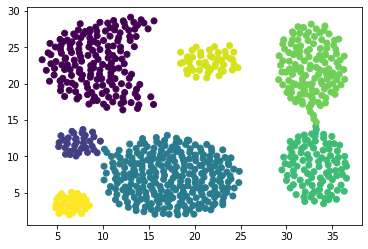

In [10]:
plot()

In [11]:
def F_ratio_test(X, cluster, labels, centers):
    n , _ = X.shape
    k = labels.shape[0]
    X_mean = np.mean(X, axis=0)
    SSW = 0
    SSB = 0
    for i in range(k):
        for j in range(n):
            if int(cluster[j]) == int(labels[i]):
                dist = ((X[j,:] - centers[i,:])**2).sum()
                SSW = SSW + dist
    
    for j in range(k):
        n_j = np.count_nonzero(cluster == labels[j])
        inter_distance = ((centers[j] - X_mean)**2).sum()
        SSB = SSB + n_j*inter_distance
    
    F = k*SSW/SSB
    return F

In [12]:
F_ratio_test(X_data,cluster,labels,centers)

0.8639409727670929